In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import h5py
import seaborn
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import pairwise_distances
import sys
sys.path.append("../")
from utils import l2_normalize, prewhiten, read_sampled_identities
from PIL import Image
seaborn.set()

In [116]:
def recall_given_dist(
    dist_self,
    dist_negative,
    k
):
    dist_self = np.sort(dist_self)
    dist_engative = np.sort(dist_negative)
    i = 0.0
    i_self = 0
    i_neg = 0
    recall_count = 0.0
    while i < k:  
        if dist_self[i_self] < dist_negative[i_neg]:
            recall_count += 1.0
            i_self += 1
        else:
            i_neg += 1

        i += 1.0

        if i_self >= len(dist_self):
            break

        if i_neg >= len(dist_negative):
            remaining_true = float(len(dist_self)) - i_self
            recall_count += remaining_true
            break
    return recall_count / min(len(dist_self), k)

def recall(
    base_embeddings, 
    negative_embeddings,
    k
):
    self_distances = pairwise_distances(
        base_embeddings,
        base_embeddings
    )#[np.tril_indices(len(base_embeddings), -1)].flatten()
    
    negative_distances = pairwise_distances(
        base_embeddings,
        negative_embeddings
    )
    
    recall = []
    for indx, dist_self in enumerate(self_distances):
        dist_self = np.delete(dist_self, indx)
        dist_negative = negative_distances[indx]
            
        recall.append(recall_given_dist(dist_self, dist_negative, k))
    return np.mean(recall)

In [117]:
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100))

1.0


In [118]:
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 100))

1.0


In [119]:
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 100))

1.0


In [120]:
print(recall_given_dist([0.0, 1.8], [1.5, 1.6], 2))

0.5


In [121]:
print(recall_given_dist([0.0, 1.0], [1.5, 1.6], 2))

1.0


In [122]:
path_to_adversarial = "/data/vggface/test_perturbed_sampled/{true}/community_naive_same/{target}/epsilon_{epsilon}.h5"
path_to_clean = "/data/vggface/test_preprocessed_sampled/{id}/embeddings.h5"

epsilons = [0.0, 0.02, 0.04, 0.06, 0.08, 0.1]

id2imnames = read_sampled_identities("../sampled_identities.txt")
identities = list(id2imnames.keys())

positive = []
negative_clean = []
negative_adv = {eps: [] for eps in epsilons}
ks = [1, 5, 10, 100, 1000]
top_k_recall = {k: {eps: [] for eps in epsilons} for k in ks}

for adversarial_target in identities:
    clean_embeddings = []
    mod_embeddings = []
    adv = {eps: [] for eps in epsilons}
    
    with h5py.File(path_to_clean.format(id=adversarial_target), "r") as f:
        clean_embeddings.extend(f["embeddings"][:])
        adv[0.0].extend(f["embeddings"][:])

    for modified_identity in identities:
        if modified_identity == adversarial_target:
            continue
        # the identity that was modified for the adversarial
        with h5py.File(path_to_clean.format(id=modified_identity), "r") as f:
            adv[0.0].extend(f["embeddings"][:])

        for indx, epsilon in enumerate(epsilons[1:]):
            with h5py.File(path_to_adversarial.format(
                target=adversarial_target,
                true=modified_identity,
                epsilon=epsilon
            ), "r") as f:
                adv[epsilon].extend(f["embeddings"][:])

    positive.extend(
        pairwise_distances(
            clean_embeddings, 
            clean_embeddings)[np.tril_indices(len(clean_embeddings), -1)].flatten()
    )
    negative_clean.extend(
        pairwise_distances(
            clean_embeddings, 
            adv[0.0]).flatten()
    )
    for indx, epsilon in enumerate(epsilons[1:]):
        negative_adv[epsilon].extend(
            pairwise_distances(clean_embeddings, adv[epsilon]).flatten()
        )
        
    for k in ks:
        for eps in epsilons:
            top_k_recall[k][eps] = recall(
                clean_embeddings, 
                adv[eps],
                k
            )


In [123]:
# colors=[
#     '#8A5998',
#     '#485682',
#     '#2F4858',
#     '#FD8D00',
#     '#FD5E5B',
#     '#D0528A',
# ]
# fig, ax = plt.subplots(nrows=1, ncols=1)
# seaborn.distplot(
#     positive,
#     kde=True,
#     hist=True,
#     label="+ (self)",
#     ax=ax,
#     color='green'
# )

# seaborn.distplot(
#     negative_clean,
#     kde=True,
#     hist=True,
#     label="- (clean)",
#     ax=ax,
#     color='red'
# )


# for indx, epsilon in enumerate(epsilons):
#     seaborn.distplot(
#         negative_adv[epsilon],
#         kde=True,
#         hist=False,
#         label="- adv epsilon={}".format(epsilon),
#         ax=ax,
#         color=colors[indx]
#     )
#     ax.set_xlabel("Normalized L2 distance to clean image")
#     ax.set_ylabel("Frequency")
#     ax.set_title("Epsilon={}".format(epsilon))

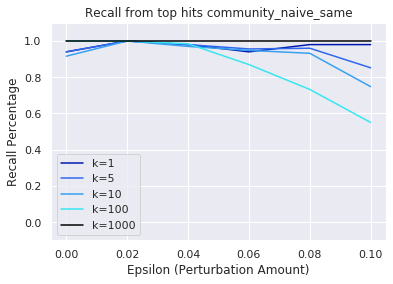

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=1)

mean_top_k_recall = {k: {eps: -1.0 for eps in epsilons} for k in ks}

colors=['#0017ad',
        '#2d67ed',
        '#37a0f0',
        '#37e6f0',
        '#000000'
       ]

for indx, k in enumerate(top_k_recall.keys()):
    epsilons = top_k_recall[k].keys()
    recall_to_plot = []
    for eps in epsilons:        
        recall_to_plot.append(top_k_recall[k][eps])
        
    ax.plot(
        list(epsilons),
        recall_to_plot,
        label="k={}".format(k),
        color=colors[indx],
    )

ax.set_ylabel("Recall Percentage")
ax.set_xlabel("Epsilon (Perturbation Amount)")
ax.set_title("Recall from top hits community_naive_same")
ax.set_ylim([-0.1, 1.1])
ax.legend()
plt.show()


In [6]:
arr = np.reshape(np.array([x for x in range(25)]), (5, 5))
print(arr)
print(arr[np.tril_indices(5, -1)])

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[ 5 10 11 15 16 17 20 21 22 23]


In [7]:
from pprint import PrettyPrinter as pp
pp().pprint(top_k_recall)

{1: {0.0: 0.0, 0.02: 1.0, 0.04: 0.82, 0.06: 0.48, 0.08: 0.6, 0.1: 0.64},
 5: {0.0: 0.292,
     0.02: 0.96,
     0.04: 0.836,
     0.06: 0.7959999999999999,
     0.08: 0.72,
     0.1: 0.26799999999999996},
 10: {0.0: 0.326,
      0.02: 0.98,
      0.04: 0.87,
      0.06: 0.74,
      0.08: 0.6439999999999999,
      0.1: 0.196},
 100: {0.0: 0.494949494949495,
       0.02: 0.9757489707475624,
       0.04: 0.6475128688128688,
       0.06: 0.3176989898989899,
       0.08: 0.17300000000000001,
       0.1: 0.08296410256410257},
 1000: {0.0: 0.494949494949495,
        0.02: 0.9757489707475624,
        0.04: 0.6648521929081913,
        0.06: 0.23455674782827884,
        0.08: 0.08884828893031653,
        0.1: 0.06540767440917751}}


In [8]:
print(identities)

['n009288', 'n002763', 'n000958', 'n002647', 'n008655', 'n003356', 'n007548', 'n008613', 'n000029', 'n009232', 'n005359', 'n003215', 'n005303', 'n005427', 'n001683', 'n001781', 'n009114', 'n004658', 'n002503']


In [9]:
# with h5py.File(path_to_clean.format(id='n008655'), "r") as f1:
#     with h5py.File(path_to_clean.format(id='n000029'), "r") as f2:
#         seaborn.distplot(
#             pairwise_distances(
#                 f1["embeddings"][:],
#                 f2["embeddings"][:]
#             ),
#             color="red",
#             label="diff"
#         )
        
#         seaborn.distplot(
#             pairwise_distances(
#                 f1["embeddings"][:],
#                 f1["embeddings"][:]
#             )[np.tril_indices(len(f1["embeddings"][:]), -1)],
#             color="green",
#             label="A self"
#         )
        
#         seaborn.distplot(
#             pairwise_distances(
#                 f2["embeddings"][:],
#                 f2["embeddings"][:]
#             )[np.tril_indices(len(f2["embeddings"][:]), -1)],
#             color="lightgreen",
#             label="B self"
#         )
#         plt.legend()

In [10]:
# model = tf.keras.models.load_model("../keras-facenet/model/facenet_keras.h5")
# with h5py.File(path_to_clean.format(id='n008655'), "r") as f1:
#     with h5py.File(path_to_clean.format(id='n000029'), "r") as f2:
#         seaborn.distplot(
#             pairwise_distances(
#                 l2_normalize(model.predict(prewhiten(f1["images"][:]))),
#                 l2_normalize(model.predict(prewhiten(f2["images"][:])))
#             ),
#             color="red",
#             label="diff"
#         )
        
#         seaborn.distplot(
#             pairwise_distances(
#                 l2_normalize(model.predict(prewhiten(f1["images"][:]))),
#                 l2_normalize(model.predict(prewhiten(f1["images"][:])))
#             )[np.tril_indices(len(f1["embeddings"][:]), -1)],
#             color="green",
#             label="A self"
#         )
        
#         seaborn.distplot(
#             pairwise_distances(
#                 l2_normalize(model.predict(prewhiten(f2["images"][:]))),
#                 l2_normalize(model.predict(prewhiten(f2["images"][:])))
#             )[np.tril_indices(len(f2["embeddings"][:]), -1)],
#             color="lightgreen",
#             label="B self"
#         )
#         plt.legend()